# Source Association in LSDB

Source Association can be run in LSDB using the `associate_sources` method on the catalog object.

To run, the method needs a `SourceAssociationAlgorithm` specified. In LSDB by default, we have the `BaselineSourceAssociationAlgorithm`. This works by using the first detected sources as objects, and cross-matching each future exposures to the current object list, adding any sources that don't match as new objects.

In [1]:
import lsdb
from lsdb.core.source_association.baseline_source_associator import BaselineSourceAssociationAlgorithm
from lsdb.core.source_association.basic_object_aggregator import BasicObjectAggregator

In [2]:
import numpy as np

In [3]:
small_sky_source = lsdb.open_catalog(
    "../../../tests/data/small_sky_source", margin_cache="../../../tests/data/small_sky_source_margin"
)
small_sky_source

,Unnamed: 0,source_id,source_ra,source_dec,mjd,mag,band,object_id,object_ra,object_dec,exposure
npartitions=14,,,,,,,,,,,
"Order: 2, Pixel: 66",int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow]
"Order: 2, Pixel: 176",...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
"Order: 2, Pixel: 187",...,...,...,...,...,...,...,...,...,...,...
"Order: 1, Pixel: 47",...,...,...,...,...,...,...,...,...,...,...


In [4]:
sa_algorithm = BaselineSourceAssociationAlgorithm(
    exposure_id_col="exposure", max_distance_arcsec=3100
)  # Specifying the name of the exposure column and the maximum distance between sources
associated_sources = small_sky_source.associate_sources(
    sa_algorithm, source_id_col="source_id", object_id_column_name="new_obj_id"
)
associated_sources

,Unnamed: 0,source_id,source_ra,source_dec,mjd,mag,band,object_id,object_ra,object_dec,exposure,new_obj_id
npartitions=14,,,,,,,,,,,,
"Order: 2, Pixel: 66",int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],int64[pyarrow]
"Order: 2, Pixel: 176",...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 2, Pixel: 187",...,...,...,...,...,...,...,...,...,...,...,...
"Order: 1, Pixel: 47",...,...,...,...,...,...,...,...,...,...,...,...


If we compute this result, we can see that we have a new object id column with the name we specified that our source association algorithm has generated.

In [5]:
computed_sources = associated_sources.compute()
computed_sources

,Unnamed: 0,source_id,source_ra,source_dec,mjd,mag,band,object_id,object_ra,object_dec,exposure,new_obj_id
_healpix_29,,,,,,,,,,,,
1188997068234845449,2125,72125,348.077158,-29.339061,58508.200151,15.090111,u,779,347.5,-29.5,243,72125
1189091599648562723,12225,82225,347.994565,-29.261689,59219.758815,18.127542,r,779,347.5,-29.5,1382,72125
...,...,...,...,...,...,...,...,...,...,...,...,...
3424289397526654168,604,70604,307.553185,-25.007915,58406.843975,16.936253,u,743,307.5,-25.5,65,76540
3424301471875806021,16081,86081,307.606224,-24.926633,59488.818985,16.745674,i,743,307.5,-25.5,1820,76540


In [6]:
computed_sources["new_obj_id"]

_healpix_29
1188997068234845449    72125
1189091599648562723    72125
                       ...  
3424289397526654168    76540
3424301471875806021    76540
Name: new_obj_id, Length: 17161, dtype: int64[pyarrow]

Assert that objects have unique exposure ids only

In [7]:
assert not np.any(np.array(computed_sources.groupby(["new_obj_id", "exposure"])["source_id"].count() > 1))

We can plot the points of our source catalog to visualize how the source association has worked.

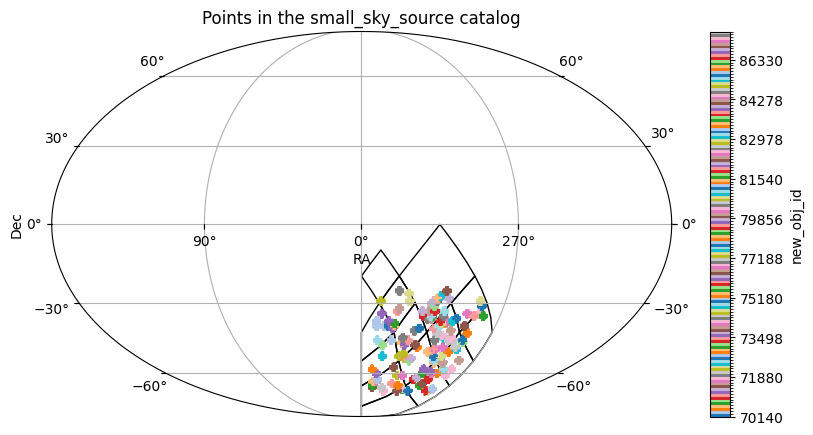

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Points in the small_sky_source catalog'}>)

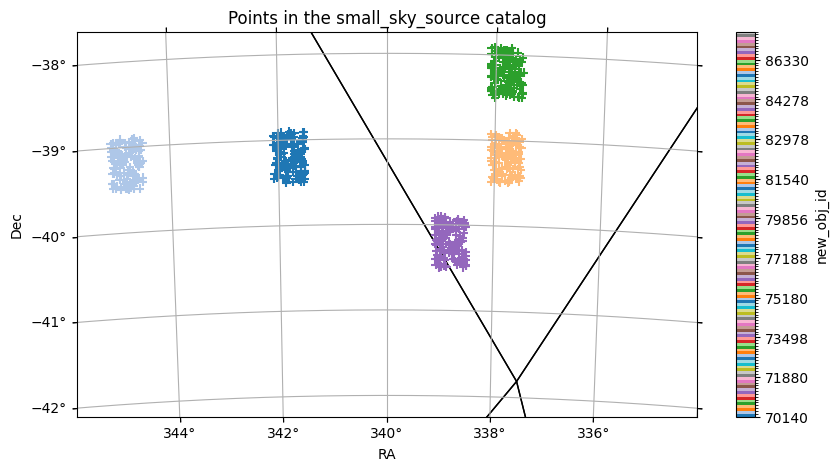

In [8]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from astropy.coordinates import SkyCoord
import astropy.units as u

unique_labels = np.unique(computed_sources["new_obj_id"])

base_cmap = plt.cm.tab20
base_colors = base_cmap.colors  # 10 colors
n_base_colors = len(base_colors)

# Create a ListedColormap with one color per unique label
repeated_colors = [base_colors[i % n_base_colors] for i in range(len(unique_labels))]
cmap = mcolors.ListedColormap(repeated_colors)

# Create boundaries so that each integer maps to a color bin
# Add ±0.5 so that integers fall in the center of their bin
boundaries = np.array(unique_labels) - 0.5
boundaries = np.append(boundaries, unique_labels[-1] + 0.5)

# BoundaryNorm maps your specific integer values to 0–N indices
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(unique_labels))

associated_sources.plot_pixels(fc="#00000000", ec="black", color_by_order=False)
associated_sources.plot_points(marker="+", color_col="new_obj_id", cmap=cmap, norm=norm)
plt.show()
associated_sources.plot_pixels(
    fc="#00000000",
    ec="black",
    color_by_order=False,
    fov=(8 * u.deg, 5 * u.deg),
    center=SkyCoord(340 * u.deg, -40 * u.deg),
)
associated_sources.plot_points(marker="+", color_col="new_obj_id", cmap=cmap, norm=norm)

## Making a Source Association Algorithm

To make a Source Association algorithm, you need to define a class that inherits the `AbstractSourceAssociationAlgorithm` class, and define the `associate_sources` method on the class, which will perform source association on a single partition. You can use the class's `__init__` to take in any parameters specific to the algorithm. You can also overwrite the `validate` method to perform any checks on the catalog to validate that the algorithm can be run at the lazy stage. (e.g. checking specific columns exist in the catalog, or that the margin is big enough).

For example, this is how the Baseline algorithm works.

In [9]:
import nested_pandas as npd
import numpy as np
from hats import HealpixPixel
from hats.catalog import TableProperties

from lsdb.core.crossmatch.kdtree_utils import _lon_lat_to_xyz, _find_crossmatch_indices, _get_chord_distance
from lsdb.core.source_association.abstract_source_association_algorithm import (
    AbstractSourceAssociationAlgorithm,
)


class NewSourceAssociationAlgorithm(AbstractSourceAssociationAlgorithm):
    def __init__(self, exposure_id_col: str, max_distance_arcsec: float):
        self.exposure_id_col = exposure_id_col
        self.max_distance_arcsec = max_distance_arcsec

    def associate_sources(
        self,
        partition: npd.NestedFrame,
        pixel: HealpixPixel,
        properties: TableProperties,
        margin_properties: TableProperties,
        source_id_col: str,
    ) -> np.ndarray:
        # Sort by exposures
        df = partition.sort_values(by=[self.exposure_id_col, source_id_col])
        # Get arrays of exposures, cartesian coords, source ids
        exposures = df[self.exposure_id_col].to_numpy()
        unique_exposures = np.unique(exposures)
        xyz = _lon_lat_to_xyz(
            lon=df[properties.ra_column].to_numpy(),
            lat=df[properties.dec_column].to_numpy(),
        )
        s_ids = df[source_id_col].to_numpy()
        # Get max xmatch distance as a chord
        max_dist_chord = _get_chord_distance(self.max_distance_arcsec)
        # Make array to assign object ids
        object_id_assignment = np.full(s_ids.shape, fill_value=-1)
        # Make array of the objects we've found so far as the indices of the source df they correspond to
        first_object_inds = np.array([])

        for e_id in unique_exposures:
            # Find rows in this exposure
            mask = exposures == e_id
            if np.all(object_id_assignment == -1):
                # If first exposure, assign all as new objects
                object_id_assignment[mask] = s_ids[mask]
                object_inds = np.where(mask)[0]
                first_object_inds = object_inds
                continue
            # Get the coordinates of the objects we've found so far
            object_xyz = xyz[first_object_inds]
            # Get the coordinates of the current exposure
            source_xyz = xyz[mask]
            # Crossmatch the current exposure to the current objects
            _, source_idx, object_idx = _find_crossmatch_indices(
                source_xyz, object_xyz, n_neighbors=1, max_distance=max_dist_chord
            )
            if len(object_idx) > 0:
                # Assign the Object ID of the objects to their matched sources
                matched_source_inds = np.where(mask)[0][source_idx]
                object_inds_for_matches = object_id_assignment[first_object_inds[object_idx]]
                object_id_assignment[matched_source_inds] = object_inds_for_matches
            # Assign new IDs to the unmatched sources, and add them as new objects
            remaining_source_idx = np.delete(np.arange(len(source_xyz)), source_idx)
            remaining_source_inds = np.where(mask)[0][remaining_source_idx]
            object_id_assignment[remaining_source_inds] = s_ids[remaining_source_inds]
            first_object_inds = np.concat([first_object_inds, remaining_source_inds])
        # Assign the object id assigment and return the Pandas Series to get the right index
        df["new_obj_id"] = object_id_assignment
        return df.sort_index()["new_obj_id"]

## Aggregating Objects

The `associate_sources` method by default returns the source catalog with the new object id column. But you can also pass in an Object Aggregator, and it will return an object catalog.

By default there is the `BasicObjectAggregator` which takes the ra and dec of the first source and uses it to define an object.

In [10]:
aggregator = BasicObjectAggregator(small_sky_source.hc_structure.catalog_info)
object_cat = small_sky_source.associate_sources(
    sa_algorithm, source_id_col="source_id", object_id_column_name="new_obj_id", object_aggregator=aggregator
)
object_cat

,object_id,ra,dec,lc
npartitions=14,,,,
"Order: 2, Pixel: 66",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<Unnamed: 0: [int64], source_id: [int64]..."
"Order: 2, Pixel: 176",...,...,...,...
...,...,...,...,...
"Order: 2, Pixel: 187",...,...,...,...
"Order: 1, Pixel: 47",...,...,...,...


By default the method will add a `lc` column with the lightcurves from the source catalog for each object. This can be controlled with the `append_lc` and `lc_name` parameters on the `ObjectAggregator` constructor.

In [11]:
object_cat.compute()

object_id          ra        dec  \
_healpix_29                                             
3188301802217094591      77024  315.696341 -68.404405   
3188347005730462383      70455  316.081218 -68.378445   
...                        ...         ...        ...   
3400274687688927599      70084  315.020432 -29.033446   
3424206178004999474      70104  307.904287 -24.967745   

                                                                    lc  
_healpix_29                                                             
3188301802217094591  [{Unnamed: 0: 12780, source_id: 82780, source_...  
3188347005730462383  [{Unnamed: 0: 866, source_id: 70866, source_ra...  
...                                                                ...  
3400274687688927599  [{Unnamed: 0: 6337, source_id: 76337, source_r...  
3424206178004999474  [{Unnamed: 0: 6540, source_id: 76540, source_r...  

[136 rows x 4 columns]

Assert that objects have unique exposure ids only

In [12]:
dups_boolean = object_cat[["lc.exposure"]].map_partitions(
    lambda x: x.map(lambda y: y["exposure"].duplicated().any())
)
dups_boolean.head(5)

,lc
_healpix_29,
3188301802217094591,False
3188347005730462383,False
3188326299492862902,False
3188377759806279350,False
3199816354861492903,False


In [13]:
arr = dups_boolean["lc"].compute()
assert len(np.where(arr)[0]) == 0

We can make another plot to visualize these

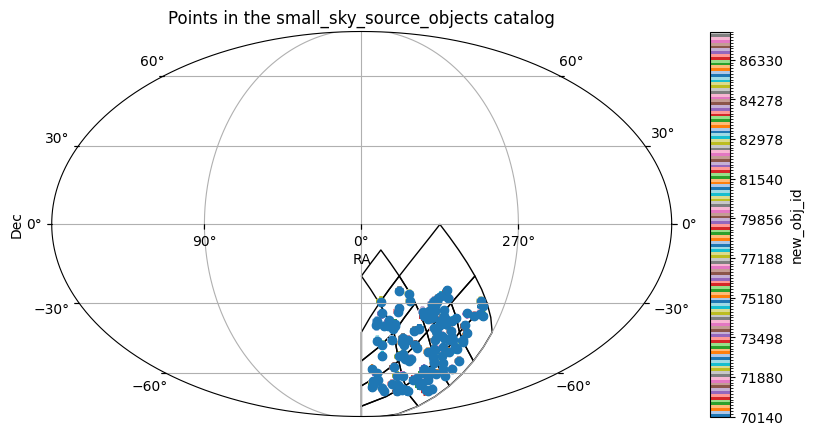

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Points in the small_sky_source_objects catalog'}>)

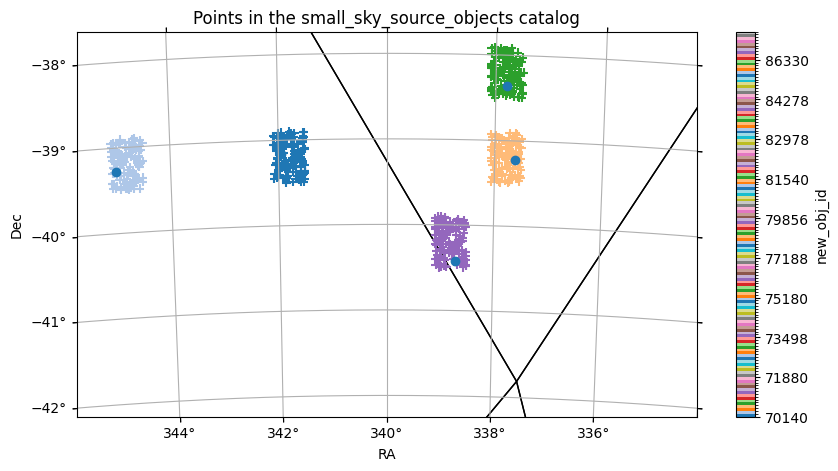

In [14]:
associated_sources.plot_pixels(fc="#00000000", ec="black", color_by_order=False)
associated_sources.plot_points(marker="+", color_col="new_obj_id", cmap=cmap, norm=norm)
object_cat.plot_points()
plt.show()
associated_sources.plot_pixels(
    fc="#00000000",
    ec="black",
    color_by_order=False,
    fov=(8 * u.deg, 5 * u.deg),
    center=SkyCoord(340 * u.deg, -40 * u.deg),
)
associated_sources.plot_points(marker="+", color_col="new_obj_id", cmap=cmap, norm=norm)
object_cat.plot_points()

## Making an ObjectAggregator

To make an `ObjectAggregator` you need to inherit from the `AbstractObjectAggregator` class and overwrite the `perform_object_aggregation` method. This method accepts a dictionary of the form `{column_name: np_array}` with the values for a single object. The method should return a dictionary of the form `{column_name: value}` for the given object. The method can return any number of columns that fit the needs of the catalog, but it must return a `ra` and `dec` column with the given names.

You must also overwrite the `get_object_meta_df` method which specifies which columns and their datatypes are to be returned from the object aggregation. For example, below is the `BasicObjectAggregator` implementation.

In [15]:
new_aggregator = BasicObjectAggregator(small_sky_source.hc_structure.catalog_info)
object_cat2 = small_sky_source.associate_sources(
    sa_algorithm,
    source_id_col="source_id",
    object_id_column_name="new_obj_id",
    object_aggregator=new_aggregator,
)

In [16]:
object_cat2.compute()

object_id          ra        dec  \
_healpix_29                                             
3188301802217094591      77024  315.696341 -68.404405   
3188347005730462383      70455  316.081218 -68.378445   
...                        ...         ...        ...   
3400274687688927599      70084  315.020432 -29.033446   
3424206178004999474      70104  307.904287 -24.967745   

                                                                    lc  
_healpix_29                                                             
3188301802217094591  [{Unnamed: 0: 12780, source_id: 82780, source_...  
3188347005730462383  [{Unnamed: 0: 866, source_id: 70866, source_ra...  
...                                                                ...  
3400274687688927599  [{Unnamed: 0: 6337, source_id: 76337, source_r...  
3424206178004999474  [{Unnamed: 0: 6540, source_id: 76540, source_r...  

[136 rows x 4 columns]

Check that ra & dec were taken from the smallest exposure

In [17]:
def min_exposure_helper(
    ra, dec, exposure, source_ra, source_dec
):  # returns (ra, dec) of smallest exposure ID
    i = np.argmin(exposure)
    return {
        "object_ra": ra,
        "object_dec": dec,
        "source_ra": source_ra[i],
        "source_dec": source_dec[i],
        "equal_ra": ra == source_ra[i],
        "equal_dec": dec == source_dec[i],
    }


reduced = object_cat2.reduce(
    min_exposure_helper,
    "ra",
    "dec",
    "lc.exposure",
    "lc.source_ra",
    "lc.source_dec",
    meta={
        "object_ra": np.float64,
        "object_dec": np.float64,
        "source_ra": np.float64,
        "source_dec": np.float64,
        "equal_ra": np.bool_,
        "equal_dec": np.bool_,
    },
)
reduced.columns

Index(['object_ra', 'object_dec', 'source_ra', 'source_dec', 'equal_ra',
       'equal_dec'],
      dtype='object')

In [18]:
ra_check, dec_check = reduced["equal_ra"].all().compute(), reduced["equal_dec"].all().compute()
assert ra_check
assert dec_check